# Prerequisites

In [1]:
import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
sys.path.append("..")

In [2]:
%load_ext autoreload
%autoreload 2

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from dataset import HWSet
from matplotlib.patches import Circle
from PIL import Image
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry
from segmenter import Segmenter
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

Using device: cuda
['sam_vit_l_0b3195.pth']
Using SAM model type ViT_L


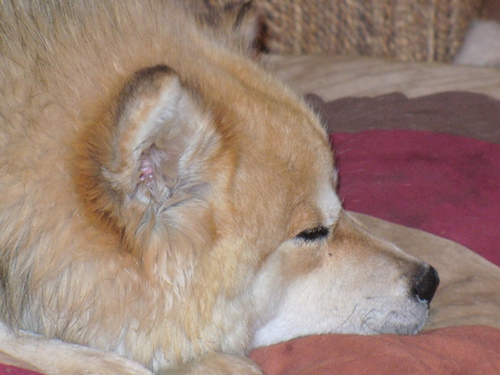

In [3]:
data_dir = "../data"
split = "train"
model_size = "L"  # H: Huge, L: Large, B: base <=> H > L > B

# out_dir = f"{data_dir}/val_images_hw_masks"
# if not os.path.exists(out_dir):
#     os.mkdir(out_dir)

model_type = f"vit_{model_size.lower()}"
model_dir_sam = f"../models/sam"

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

# Model checkpoints
checkpoints = os.listdir(model_dir_sam)
print(checkpoints)

checkpoint = None
for cpt in checkpoints:
    if model_type in cpt:
        checkpoint = cpt
assert checkpoint is not None, f"Could not find model type {model_type} checkpoint."
checkpoint = f"{model_dir_sam}/{checkpoint}"
print(f"Using SAM model type ViT_{model_size.upper()}")

# Load model
sam = sam_model_registry[model_type](checkpoint=checkpoint)
sam.to(device)
predictor = SamPredictor(sam)

# dset = HWSet(data_dir, transform=transforms.Resize(256, antialias=True))
dset = HWSet(data_dir, split, transform=None)
im, label = dset[0]
im

In [4]:
indices = []
if split == 'train':
    mask_files = []
    for img_dir in dset.train_img_dirs:
        out_dir = f"{img_dir}_masks"
        if not os.path.exists(out_dir):
            os.mkdir(out_dir)
        mask_files.extend([file.split('.')[0] for file in os.listdir(out_dir)])
    for idx in range(len(dset)):
        if os.path.split(dset.imgs[idx])[-1].split('.')[0] not in mask_files:
            indices.append(idx)
elif split == 'val':
    out_dir = f"{dset.val_img_dir}_masks"
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

    mask_files = [file.split('.')[0] for file in os.listdir(out_dir)]
    for idx in range(len(dset)):
        if os.path.split(dset.imgs[idx])[-1].split('.')[0] not in mask_files:
            indices.append(idx)

len(indices)

0

In [5]:
%matplotlib widget
# indices = iter(range(len(dset)))
indices = iter(indices)

# Segmentation Loop

In [6]:
idx = next(indices)
im, label = dset[idx]
out_dir, fname = os.path.split(dset.imgs[idx])
plt.close('all')
Segmenter(np.array(im.convert('RGB')), sam, device=device, name=f"{out_dir}_masks/{fname.split('.')[0]}")

StopIteration: 